<a href="https://colab.research.google.com/github/lanyu0322/phd_semester1/blob/master/NYC_jobs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
 #LEHD data for NYC.  And make a choropleth of the number of workers to residents.
  

In [0]:
from google.colab import drive
drive.mount("/content/drive")



Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
!pip install geopandas

     |████████████████████████████████| 901kB 4.3MB/s 
     |████████████████████████████████| 11.9MB 21.0MB/s 
     |████████████████████████████████| 10.1MB 42.8MB/s 
  Created wheel for munch: filename=munch-2.3.2-py2.py3-none-any.whl size=6614 sha256=ea42304f924192df44f7f1b240b2ab5c2c123b2cbea217eefa208a7498aefb23
  Stored in directory: /root/.cache/pip/wheels/db/bf/bc/06a3e1bfe0ab27d2e720ceb3cff3159398d92644c0cec2c125
Successfully built munch


In [0]:
import time
import geopandas as gp
import numpy as np
import matplotlib.pyplot as plt
import geopandas as gp
import pyproj as proj
import pandas as pd

In [0]:
wname = "drive/My Drive/lwir/data/nyc_ratio/ny_wac_S000_JT00_2017.csv"
rname = "drive/My Drive/lwir/data/nyc_ratio/ny_rac_S000_JT00_2017.csv"
tname = "drive/My Drive/lwir/data/nyc_ratio/ny_od_main_JT00_2017.csv"



In [0]:
wdata = pd.read_csv(wname)
wdata.head()



,w_geocode,C000,CA01,CA02,CA03,CE01,CE02,CE03,CNS01,CNS02,CNS03,CNS04,CNS05,CNS06,CNS07,CNS08,CNS09,CNS10,CNS11,CNS12,CNS13,CNS14,CNS15,CNS16,CNS17,CNS18,CNS19,CNS20,CR01,CR02,CR03,CR04,CR05,CR07,CT01,CT02,CD01,CD02,CD03,CD04,CS01,CS02,CFA01,CFA02,CFA03,CFA04,CFA05,CFS01,CFS02,CFS03,CFS04,CFS05,createdate
0,360010001001004,5,1,3,1,2,2,1,0,0,0,0,0,0,0,0,2,0,0,0,0,3,0,0,0,0,0,0,4,1,0,0,0,0,4,1,2,1,0,1,2,3,0,0,0,0,0,0,0,0,0,0,20190825
1,360010001001005,57,11,39,7,3,8,46,0,0,0,44,0,13,0,0,0,0,0,0,0,0,0,0,0,0,0,0,56,1,0,0,0,0,54,3,7,15,17,7,50,7,0,0,0,0,0,0,0,0,0,0,20190825
2,360010001001006,43,5,27,11,1,5,37,0,0,0,0,0,0,0,0,0,0,38,5,0,0,0,0,0,0,0,0,39,3,0,0,0,1,42,1,7,11,8,12,41,2,0,0,0,0,0,0,0,0,0,0,20190825
3,360010001001008,104,28,53,23,17,30,57,0,0,0,20,0,82,0,0,0,0,0,0,0,0,2,0,0,0,0,0,79,13,0,10,0,2,100,4,12,26,21,17,79,25,0,0,0,0,0,0,0,0,0,0,20190825
4,360010001001010,3,1,2,0,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3,0,0,3,0,0,0,0,0,3,0,0,1,0,1,0,3,0,0,0,0,0,0,0,0,0,0,20190825


In [0]:
print(len(wdata))

tdata = pd.read_csv(tname)


107774


In [0]:
wtotal = wdata['C000'].sum()



In [0]:
rdata = pd.read_csv(rname)


In [0]:
len(rdata)

231315

In [0]:
# Creating the map:
# # 1. merge wdata and rdata on the "geocode" columns (with suffixes "_w" and "_h") and fill NaNs with zeros (fillna is the method)
wdata = pd.read_csv(wname)
rdata = pd.read_csv(rname)
# display(wdata.head(), rdata.head())


# ===== wrong one
# merged = pd.merge(wdata[["w_geocode", 'C000']], rdata[["h_geocode",'C000']], left_on="w_geocode", right_on="h_geocode", suffixes=["_w", "_h"], how='outer', left_index=True)
# print(merged)
# merged[['C000_w', 'C000_h']] = merged[['C000_w','C000_h']].fillna(value=0) 
# print(merged)

wdata.rename(columns = {'w_geocode': 'GEOID10'}, inplace=True)
rdata.rename(columns = {'h_geocode': 'GEOID10'}, inplace=True)

merged = pd.merge(wdata[["GEOID10", 'C000']], rdata[["GEOID10",'C000']], on="GEOID10", suffixes=["_w", "_h"], how='outer')
#print(merged)


In [0]:
# # 2. sum the C000_w and C000_h columns and add the result to the output of 1.
merged[['C000_w', 'C000_h']] = merged[['C000_w','C000_h']].fillna(value=0) 
merged['total'] = merged['C000_w'] + merged['C000_h']
#print(merged)

In [0]:
#3. get the census blocks shapefile for NY state (either census data website or bytes of the big apple website)
# 4. sub-sample to only Manhattan
fname = "drive/My Drive/lwir/data/nyc_ratio/tl_2019_36_tabblock10/tl_2019_36_tabblock10.shp"
#data source:https://www2.census.gov/geo/tiger/TIGER2019/TABBLOCK/
#data agenda:https://www2.census.gov/geo/pdfs/maps-data/data/tiger/tgrshp2019/TGRSHP2019_TechDoc.pdf

t0 = time.time()
print("reading census tract shapes for NY state")
data = gp.read_file(fname)
print("  read in {0}s".format(time.time() - t0))
data.head()

# 005 # Bronx County
# 047 # Kings County (Brooklyn)
# 081 # Queens County
# 085 # Richmond County (Staten Island)

# manhattan = data["COUNTRYPF10"] == "061"  wrong one, because the output is true/false
ind = (data.COUNTYFP10 == "005") | (data.COUNTYFP10 == "047") | \
  (data.COUNTYFP10 == "061") | (data.COUNTYFP10 == "081") | \
  (data.COUNTYFP10 == "085")
# manhattan = data[data.COUNTYFP10 == "061"]
manhattan = data[ind] # all NYC counties
#061 - New York (Manhattan) source: https://test.library.columbia.edu/services/research-data-services/guides/population/nycounty_fips.html
#manhattan.head()
#print(manhattan)


reading census tract shapes for NY state
  read in 23.798351049423218s


In [0]:
# 5. merge the output of 2. into the geodataframe of 4.
manhattan['GEOID10'] = manhattan['GEOID10'].astype(int) #the orginal type is object, we use this sentence to transfer interge 就是他本来的type是object，然后通过这句话把它转成int, 数据类型一致了下面才能merge
# “You are trying to merge on object and int64 columns. If you wish to proceed you should use pd.concat”，意思就是一个数据类型是int，一个是object

sub = manhattan.merge(merged, on='GEOID10', how='left')
sub[['C000_w', 'C000_h']] = sub[['C000_w','C000_h']].fillna(value=0) 
sub['total'] = sub['C000_w'] + sub['C000_h']
print(sub)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


      STATEFP10 COUNTYFP10 TRACTCE10  ... C000_w  C000_h  total
0            36        085    002001  ...    0.0     0.0    0.0
1            36        085    000800  ...    5.0    64.0   69.0
2            36        085    017012  ...    4.0    34.0   38.0
3            36        085    018701  ...    0.0    53.0   53.0
4            36        085    018701  ...    0.0     0.0    0.0
5            36        005    023900  ...   94.0   270.0  364.0
6            36        085    017600  ...   15.0    19.0   34.0
7            36        005    018400  ...    2.0   179.0  181.0
8            36        085    007000  ...    3.0    94.0   97.0
9            36        005    040600  ...    0.0   184.0  184.0
10           36        085    017009  ...    2.0    47.0   49.0
11           36        085    022300  ...    0.0     0.0    0.0
12           36        085    000800  ...    0.0     2.0    2.0
13           36        005    016600  ...    0.0    99.0   99.0
14           36        005    011000  ..

In [0]:
# -- remove census tracts with 0 residents or workers
#sub_nz = sub[sub.total != 0]

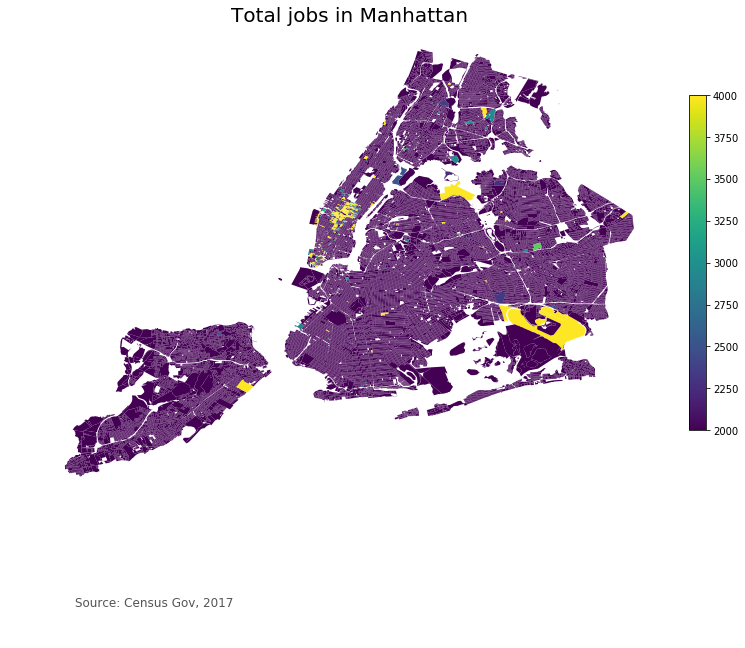

In [0]:
#6. plot the map of 2

# set the filepath and load in a shapefile
# check data type so we can see that this is not a normal dataframe, but a GEOdataframe
nyc_jobs = "total"
# vmin, vmax = 0, 28323 #better way: sub['total'].min()/max
vmin, vmax = 2000, 4000 #better way: sub['total'].min()/max
fig, ax = plt.subplots(1, figsize=(12, 12))
sub_nz.plot(column=nyc_jobs, cmap='viridis', linewidth=0.0, ax=ax, edgecolor='0.3', vmin=vmin, vmax=vmax)
ax.axis("off")
ax.set_title("Total jobs in Manhattan", fontdict={"fontsize": "20", "fontweight": "7"})
ax.annotate("Source: Census Gov, 2017",xy=(0.1, .08),  xycoords="figure fraction", horizontalalignment="left", verticalalignment="top", fontsize=12, color="#555555")
# Create colorbar as a legend
sm = plt.cm.ScalarMappable(cmap='viridis', norm=plt.Normalize(vmin=vmin, vmax=vmax))                # normalize意思就是把所有的数据都归一化，意思就是把所有数据按比例整理一下，这里的比例就是括号里的最大最小值，比如有5个数[1.34, 3.34, 4.32, 3, 5.43], 按[0,1]归一化以后就是 [0.134, 0.334, 0.432, 0.3, 0.543]
sm._A = [] # empty array for the data range                                                   # 我查了一下源码，_A应该是这个cm （color map）的一个变量，是一个数组，意思就是标识数据范围的一个array，应该不用管，传个空的就是了
cbar = fig.colorbar(sm,fraction=0.025, pad=0.04) # add the colorbar to the figure


plotting workers...
plotting residents...
plotting total...


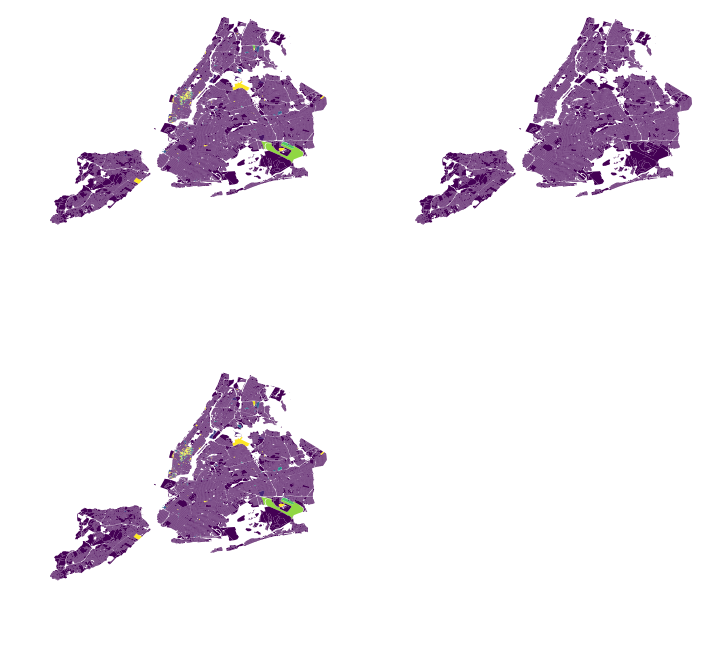

In [0]:
# -- plot workers, residents, and total side by side
clim    = (2000, 5000)
fig, ax = plt.subplots(2, 2, figsize=(12, 12))
[i.axis("off") for j in ax for i in j]

print("plotting workers...")
sub_nz.plot(column="C000_w", lw=0.0, ax=ax[0][0], vmin=clim[0], vmax=clim[1])
print("plotting residents...")
sub_nz.plot(column="C000_h", lw=0.0, ax=ax[0][1], vmin=clim[0], vmax=clim[1])
print("plotting total...")
sub_nz.plot(column="total", lw=0.0, ax=ax[1][0], vmin=clim[0], vmax=clim[1])



# nyc_jobs = "total"
# # vmin, vmax = 0, 28323 #better way: sub['total'].min()/max
# vmin, vmax = 2000, 4000 #better way: sub['total'].min()/max
# fig, ax = plt.subplots(1, figsize=(12, 12))
# sub_nz.plot(column=nyc_jobs, cmap='viridis', linewidth=0.0, ax=ax, edgecolor='0.3', vmin=vmin, vmax=vmax)
# ax.axis("off")
# ax.set_title("Total jobs in Manhattan", fontdict={"fontsize": "20", "fontweight": "7"})
# ax.annotate("Source: Census Gov, 2017",xy=(0.1, .08),  xycoords="figure fraction", horizontalalignment="left", verticalalignment="top", fontsize=12, color="#555555")
# # Create colorbar as a legend
# sm = plt.cm.ScalarMappable(cmap='viridis', norm=plt.Normalize(vmin=vmin, vmax=vmax))                # normalize意思就是把所有的数据都归一化，意思就是把所有数据按比例整理一下，这里的比例就是括号里的最大最小值，比如有5个数[1.34, 3.34, 4.32, 3, 5.43], 按[0,1]归一化以后就是 [0.134, 0.334, 0.432, 0.3, 0.543]
# sm._A = [] # empty array for the data range                                                   # 我查了一下源码，_A应该是这个cm （color map）的一个变量，是一个数组，意思就是标识数据范围的一个array，应该不用管，传个空的就是了
# cbar = fig.colorbar(sm,fraction=0.025, pad=0.04) # add the colorbar to the figure


In [0]:
# -- how many have 0 workers plus residents?
print((sub.total == 0).sum())
print(len(sub))

5930
39148


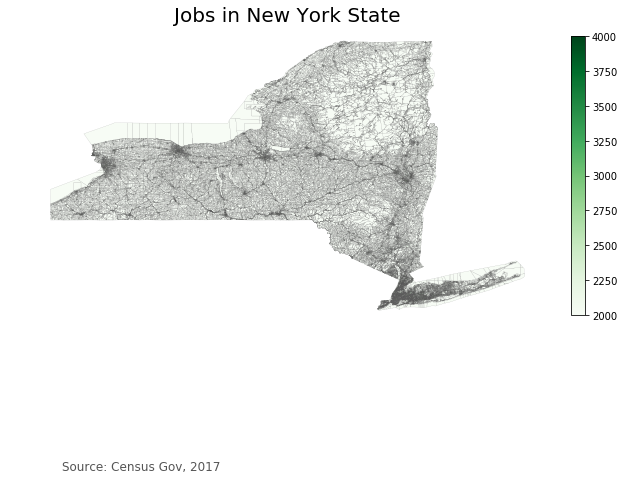

In [0]:
wdata.rename(columns = {'w_geocode': 'GEOID10'}, inplace=True)
rdata.rename(columns = {'h_geocode': 'GEOID10'}, inplace=True)

merged = pd.merge(wdata[["GEOID10", 'C000']], rdata[["GEOID10",'C000']], on="GEOID10", suffixes=["_w", "_h"], how='outer')

fname = "drive/My Drive/lwir/data/nyc_ratio/tl_2019_36_tabblock10/tl_2019_36_tabblock10.shp"
#data source:https://www2.census.gov/geo/tiger/TIGER2019/TABBLOCK/
#data agenda:https://www2.census.gov/geo/pdfs/maps-data/data/tiger/tgrshp2019/TGRSHP2019_TechDoc.pdf
data = gp.read_file(fname)
data.head()
data['GEOID10'] = data['GEOID10'].astype(int) 
ny_state = data.merge(merged, on='GEOID10', how='left')
ny_state[['C000_w', 'C000_h']] = ny_state[['C000_w','C000_h']].fillna(value=0) 
ny_state['total'] = ny_state['C000_w'] + ny_state['C000_h']
#print(ny_state)
jobs = "total"
tmin, tmax = 1, 11814
fig, ax = plt.subplots(1, figsize=(10,10))
ny_state.plot(column=jobs, cmap='Greens', linewidth=0.08, ax=ax, edgecolor='0.3')
ax.axis("off")
ax.set_title("Jobs in New York State", fontdict={"fontsize": "20", "fontweight": "7"})
ax.annotate("Source: Census Gov, 2017",xy=(0.1, .08),  xycoords="figure fraction", horizontalalignment="left", verticalalignment="top", fontsize=12, color="#555555")
sm = plt.cm.ScalarMappable(cmap='Greens', norm=plt.Normalize(vmin=vmin, vmax=vmax)) # Create colorbar as a legend
sm._A = [] # empty array for the data range
cbar = fig.colorbar(sm,fraction=0.025, pad=0.04) # add the colorbar to the figure


In [0]:

#Let's put together the parks and LEHD notebooks so that we can have integrated square 
# footage and W+R within some "aperture" (aka radius) around each camera lat/lon.  
# Once we have that, 
# let's also look at a scatter plot of those two quantities.  Once we have those two, I'll give you the foot traffic data.


# Bear in mind that when integrating the parks data,
# it's easy: inside park is 1 outside park is 0. 
# For W+R it's a bit more complicated.  
# Once the intersection is done,
# you have a geodataframe with a series of gemoetries, many of which are empty.  
# For each of those geometries, you can calculate the area and what you want for that geometry is the fraction of W+R that that area represents.


In [0]:
GEOID10=sub['GEOID10']
import pyproj
from shapely.geometry import Point  
# def available_space(geometry, lat, lon, rad):
#   circle = Point(lat,lon).buffer(rad)
#   area = geometry.intersection(circle)  
#   result = area.area.sum()
#   return result

def area_fraction(geometry, lat, lon, rad):
  circle = Point(lat,lon).buffer(rad)
  inter = geometry.intersection(circle)  
  result = inter.area/geometry.area
  return result


sub = sub.to_crs(epsg=2263)  
gemo = sub['geometry']
lname = "drive/My Drive/lwir/data/nycdot/cam need fullfill.npy"
latlon = np.load(lname)

def latlon_to_ny(lat, lon):
    """ lat/lon to NYS """

    proj = pyproj.Proj(init="epsg:2263", preserve_units=True)
    result = proj(lon, lat)

    return result


ny_lat, ny_lon = latlon_to_ny(latlon[:, 0], latlon[:, 1])
ny_latlon = np.vstack((ny_lat, ny_lon)).T


# rad = 500.
# area_size = []
# for i in range(ny_latlon.shape[0]):
#   jarea = available_space(gemo, ny_latlon[i][0], ny_latlon[i][1], rad)
#   area_size.append(jarea)
# #area_size = np.array(area_size)
# print(area_size)

rad = 500.
#area_size = []
#for i in range(ny_latlon.shape[0]):
jarea = area_fraction(gemo, ny_latlon[0][0], ny_latlon[0][1], rad)
totaljobs = jarea * sub["total"]

#area_size.append(jarea)
#area_size = np.array(area_size)
#print(area_size)


In [0]:
# print(jarea)
# print(totaljobs)
totaljobs.sum()

346.77553587831216

In [0]:
def available_greenspace(geometry, lat, lon, rad):
  circle = Point(lat,lon).buffer(rad)
  parea = geometry.intersection(circle)   
  result = parea.area.sum()
  return result

#intersection_parks = park.geometry.intersection(circle)     
# -- Read parks properties
#props = READ IN THE PROPOERTIES FILE
fname = "drive/My Drive/lwir/data/parks/properties/geo_export_5b605687-0f81-4fe4-9fb7-ec27cd43ab5f.shp"

#read the godataframe and # -- Convert to NYSP coords

park = gp.GeoDataFrame.from_file(fname)

park = park.to_crs(epsg=2263) 
gemo = park['geometry']




lname = "drive/My Drive/lwir/data/nycdot/need fullfill.npy"
latlon = np.load(lname)
# len(latlon) #281

def latlon_to_ny(lat, lon):
    """ lat/lon to NYS """

    proj = pyproj.Proj(init="epsg:2263", preserve_units=True)
    result = proj(lon, lat)

    return result



ny_lat, ny_lon = latlon_to_ny(latlon[:, 0], latlon[:, 1])
ny_latlon = np.vstack((ny_lat, ny_lon)).T




rad = 500.


greenarea_size = []

for i in range(ny_latlon.shape[0]): #for in in range(len(latton))

  tarea = available_greenspace(gemo, ny_latlon[i][0], ny_latlon[i][1], rad)
  greenarea_size.append(tarea)

greenareaa_size = np.array(greenarea_size)
print(greenarea_size)
 


import pandas as pd
import matplotlib.pyplot as plt
import numpy as np



[0.0, 979.8064743176856, 0.0, 45023.62456460086, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 58445.16428738835, 0.0, 19998.479163659733, 0.0, 0.0, 27738.52437648816, 0.0, 0.0, 106125.95056684192, 55087.99869758377, 0.0, 8320.291016319372, 0.0, 275257.69398205954, 0.0, 0.0, 157510.83975452487, 66006.33318213576, 0.0, 160457.4507086348, 0.0, 5065.4175646376825, 0.0, 0.0, 0.0, 774.7542460965503, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 3181.931609328875, 15459.035162358396, 0.0, 0.0, 0.0, 0.0, 9901.365924108217, 0.0, 0.0, 0.0, 0.0, 107791.03341599465, 514710.04717474314, 6959.067569210872, 85853.0714735885, 0.0, 0.0, 0.0, 0.0, 0.0, 89724.2388952635, 0.0, 46133.939657332485, 76137.13705631309, 23405.802278549065, 0.0, 32399.135984912533, 5048.691858165191, 0.0, 0.0, 0.0, 0.0, 65605.86242678041, 23.604972735422823, 0.0, 0.0, 0.0, 341611.1816233444, 340411.0756514045, 0.0, 0.0, 337377.13809223304, 119475.6375219297, 31554.40163325733, 0.0, 3306.7293711453185, 55231.85039356697, 1533.9693687962922, 878.117842640

In [0]:
# 2. Using the output of 1 to calculate the s+w 
tarea_size = []
for index, row in sub.iterrows():
  poly_area = row['geometry'].area    
  tarea_size.append(poly_area)
#tarea_size = np.array(tarea_size)

print(tarea_size)


[142656.49895362792, 210654.21983010665, 156606.9835788162, 171031.4033734627, 195766.9490941271, 208846.56107447593, 227009.3210197207, 260603.92591915443, 236711.9008439879, 239980.9116324097, 201028.98604650595, 6751248.718521961, 51029.96797269467, 201309.44412356816, 287567.7896219207, 125734.37029926824, 518571.7059451815, 16487.19154083296, 47805.36325670821, 206101.93294344703, 100521.49525410795, 59788.322156416165, 14350.53224586086, 143978.2686250945, 234251.1215694141, 223803.1645473023, 40774.70488016804, 18288.69694539047, 235004.84747995296, 235553.1282198106, 107273.46463748546, 78928.99471668467, 536586.4295135408, 533032.4374594553, 75024.04407021306, 176711.15067270567, 106222.06839771844, 85406.72706528673, 58149.000703810605, 50358.066132693915, 119902.29655567872, 82061.88783412584, 156660.17824134525, 5262946.23971049, 98015.97056232447, 143423.20122134383, 97697.0434842702, 117089.7381216646, 48492.818267677896, 30256.936266059907, 198641.0447469235, 180828.6279

In [0]:
len(tarea_size)
len(area_size)

281

In [0]:

area_fraction = []
for i in range(281):
  fraction = area_size[i]/tarea_size[i]
  area_fraction.append(fraction)
print(area_fraction)
jobs = area_fraction*sub['total']

In [0]:
#merge the data
#plot
fig, ax = plt.subplots(figsize=(20, 20))

ax.set_title('Parks sq-ft vs Total Jobs')
ax.set_xlabel('Parks sq-ft')
ax.set_ylabel('Total Jobs')
ax.set_facecolor("lightgray")

